In [1]:
# Compute attribution for the greater-than dataset. 

from sae_eap.model.load_pretrained import load_model

model = load_model('gpt2')

/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [2]:
from sae_eap.data.gt import GreaterThanHandler

handler = GreaterThanHandler(model)

In [3]:
from sae_eap.data.gt import EAPDataset

ds = EAPDataset("../examples/eap_ig/greater_than_data.csv")
dataloader = ds.to_dataloader(12)
# iter over a single batch
def as_single_batch(dataloader):
    for batch in dataloader:
        yield batch 
        break

In [4]:
from sae_eap.graph import build

graph = build.build_graph(model)

/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
from sae_eap.attribute import run_attribution

# loader = dataloader
loader = as_single_batch(dataloader)


def iter_batch_handler(handler, loader):
    for batch in loader:
        with handler.handle(*batch):
            yield handler


attribution = run_attribution(model, graph, iter_batch_handler(handler, loader))

1it [00:00,  1.83it/s]
100%|██████████| 32491/32491 [00:00<00:00, 840469.78it/s]


# Analysis

In [6]:
# Load the original scores

from sae_eap.core.constants import ProjectDir
from sae_eap.attribute import load_attribution_scores

orig_scores = load_attribution_scores(ProjectDir / "examples" / "eap_ig", "eap_scores_gt_single_orig.pkl")

In [7]:
print(len(attribution))
print(len(orig_scores))

32491
32491


In [8]:
i = 0 
for orig, attr in zip(orig_scores.items(), attribution.items()):
    print (orig, attr)
    i += 1
    if i >= 5:
        break

('input->a0.h0<q>', 4.8105325e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H0.in_q, blocks.0.hook_q_input, head=0)', 0.00057726365)
('input->a0.h0<k>', -7.252532e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H0.in_k, blocks.0.hook_k_input, head=0)', -0.00087030366)
('input->a0.h0<v>', -1.9773892e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H0.in_v, blocks.0.hook_v_input, head=0)', -0.00023728676)
('input->a0.h1<q>', 2.7531647e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H1.in_q, blocks.0.hook_q_input, head=1)', 0.0003303797)
('input->a0.h1<k>', 3.8477232e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H1.in_k, blocks.0.hook_k_input, head=1)', 0.0004617268)


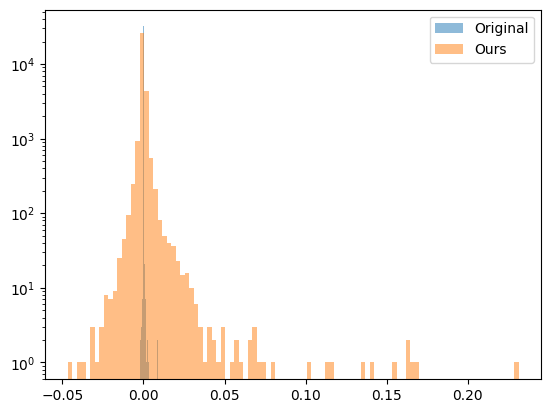

In [9]:
# Plot the distribution of scores. 

import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.hist(orig_scores.values(), bins=100, log=True, label="Original", alpha = 0.5)
ax.hist(attribution.values(), bins=100, log=True, label="Ours", alpha = 0.5)
ax.legend()

In [10]:
print(max(orig_scores.values()))
print(max(attribution.values()))

print(min(orig_scores.values()))
print(min(attribution.values()))

0.015291664
0.23121372
-0.006104128
-0.046768006


In [11]:
for orig_edge_name, our_edge_name in zip(orig_scores.keys(), attribution.keys()):
    print(orig_edge_name, our_edge_name)

input->a0.h0<q> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H0.in_q, blocks.0.hook_q_input, head=0)
input->a0.h0<k> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H0.in_k, blocks.0.hook_k_input, head=0)
input->a0.h0<v> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H0.in_v, blocks.0.hook_v_input, head=0)
input->a0.h1<q> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H1.in_q, blocks.0.hook_q_input, head=1)
input->a0.h1<k> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H1.in_k, blocks.0.hook_k_input, head=1)
input->a0.h1<v> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H1.in_v, blocks.0.hook_v_input, head=1)
input->a0.h2<q> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H2.in_q, blocks.0.hook_q_input, head=2)
input->a0.h2<k> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H2.in_k, blocks.0.hook_k_input, head=2)
input->a0.h2<v> SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H2.in_v, blocks.0.hook_v_input, head=2)
input->a0.h3<q> Src

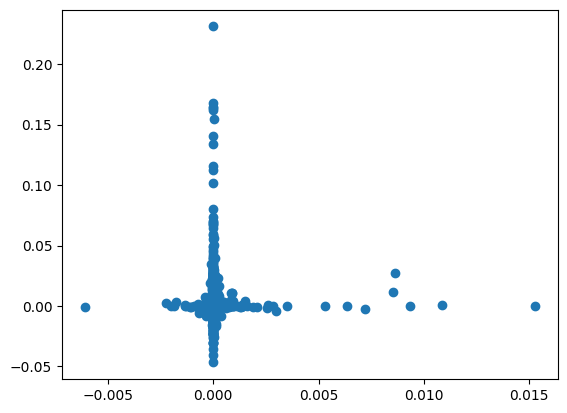

In [12]:
plt.scatter(orig_scores.values(), attribution.values())